In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img1 = cv2.imread('img1.jpg',0)

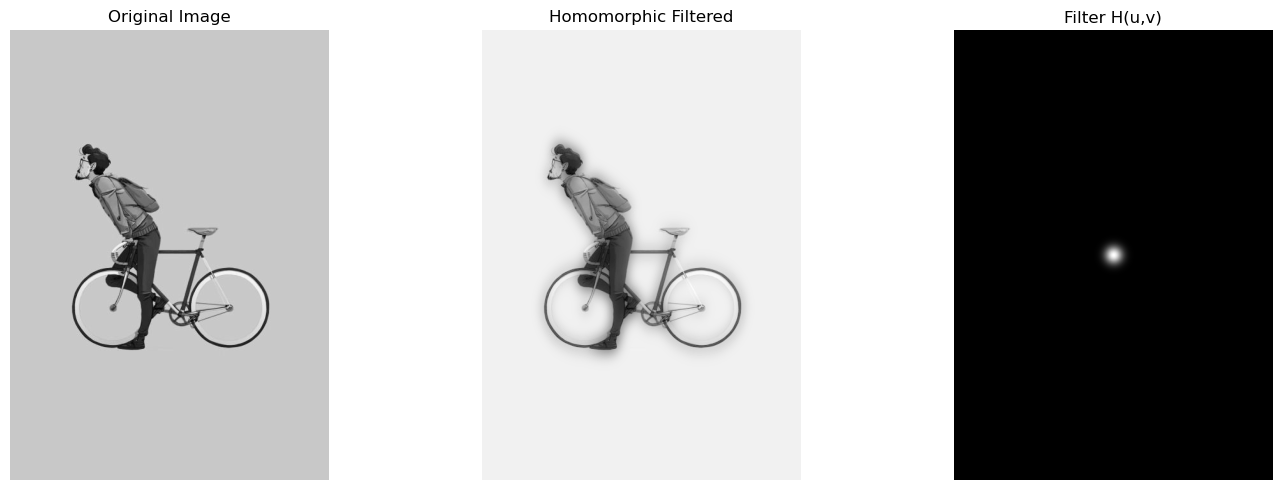

In [5]:

def homomorphic_filter_correct(image, cutoff=30, gamma_low=2, gamma_high=1, c=1):
    img_float = np.float32(image)
    img_log = np.log(img_float + 1)
    dft = cv2.dft(img_log, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    rows, cols = img_log.shape
    crow, ccol = rows // 2, cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    u, v = np.meshgrid(u, v, indexing='ij')
    D = np.sqrt((u - crow)**2 + (v - ccol)**2)
    
    H = (gamma_high - gamma_low) * (1 - np.exp(-c * (D**2) / (cutoff**2))) + gamma_low
    filtered_dft = dft_shift * H[:, :, np.newaxis]
    
    idft_shift = np.fft.ifftshift(filtered_dft)
    img_filtered = cv2.idft(idft_shift, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    img_filtered = np.real(img_filtered)
    
    img_exp = np.exp(img_filtered) - 1
    img_normalized = cv2.normalize(img_exp, None, 0, 255, cv2.NORM_MINMAX)
    result = np.uint8(img_normalized)
    
    return result, H

filtered_img, H = homomorphic_filter_correct(img1, 30, 1, 0.5, 5)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(img1, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(filtered_img, cmap='gray')
plt.title('Homomorphic Filtered')
plt.axis('off')

plt.subplot(133)
plt.imshow(H, cmap='gray')
plt.title('Filter H(u,v)')
plt.axis('off')

plt.tight_layout()
plt.show()

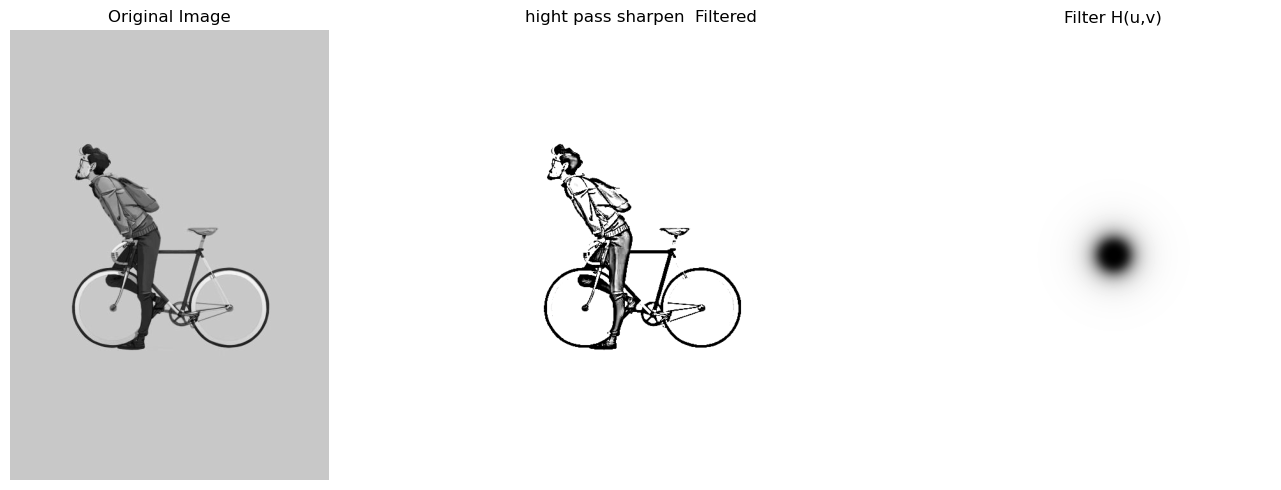

In [ ]:

def highpass_filter_sharpen(image, cutoff=30, filter_type='gaussian' , alpha = 2.0 , beta = 2):
    img_float = np.float32(image)
    dft = cv2.dft(img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    u, v = np.ogrid[:rows, :cols]
    D = np.sqrt((u - crow)**2 + (v - ccol)**2)
    
    # High-pass filters
    if filter_type == 'ideal':
        H = np.zeros((rows, cols))
        H[D > cutoff] = 1
    elif filter_type == 'butterworth':
        n = 2  
        H = 1 / (1 + (cutoff / (D + 1e-6))**(2*n))
    elif filter_type == 'gaussian':
        H = 1 - np.exp(-(D**2) / (2 * cutoff**2))

    H_sharp = beta + alpha * H  
    filtered_dft = dft_shift * H_sharp[:, :, np.newaxis]
    idft_shift = np.fft.ifftshift(filtered_dft)
    img_back = cv2.idft(idft_shift, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    img_sharp = np.real(img_back)
    img_sharp = np.clip(img_sharp, 0, 255)
    result = np.uint8(img_sharp)
    
    return result, H_sharp

sharpened_img, H = highpass_filter_sharpen(img1, cutoff=30, filter_type='butterworth' , alpha = 10)
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(img1, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(sharpened_img, cmap='gray')
plt.title('hight pass sharpen  Filtered')
plt.axis('off')

plt.subplot(133)
plt.imshow(H, cmap='gray')
plt.title('Filter H(u,v)')
plt.axis('off')

plt.tight_layout()
plt.show()

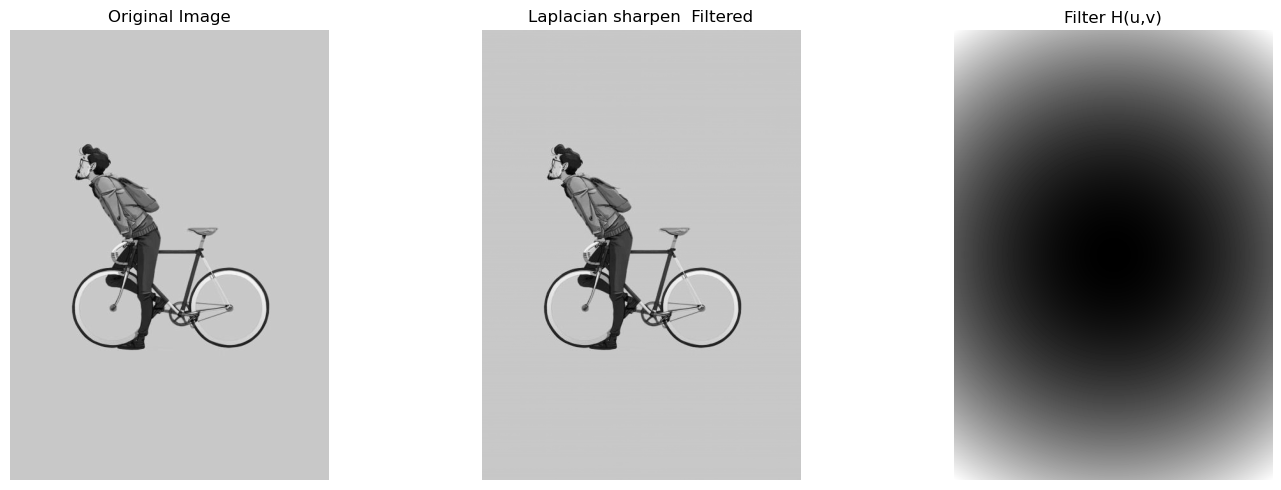

In [28]:
def laplacian_sharpen_frequency(image, alpha=0.5):
    img_float = np.float32(image)
    dft = cv2.dft(img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    rows, cols = image.shape
    u = np.arange(rows) - rows//2
    v = np.arange(cols) - cols//2
    u, v = np.meshgrid(v, u)
    H_laplacian = -4 * np.pi**2 * (u**2 + v**2)
    H_sharp = 1 - alpha * H_laplacian / np.max(np.abs(H_laplacian))
    filtered_dft = dft_shift * H_sharp[:, :, np.newaxis]
    img_back = np.fft.ifftshift(filtered_dft)
    idft_shift = cv2.idft(img_back , flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    img_sharp = np.real(idft_shift)
    img_sharp = np.clip(img_sharp, 0, 255)
    result = np.uint8(img_sharp)
    
    return result, H_sharp

laplacian_sharp, H_laplacian = laplacian_sharpen_frequency(img1, alpha=0.0001 )
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(img1, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(laplacian_sharp, cmap='gray')
plt.title('Laplacian sharpen  Filtered')
plt.axis('off')

plt.subplot(133)
plt.imshow(H_laplacian, cmap='gray')
plt.title('Filter H(u,v)')
plt.axis('off')

plt.tight_layout()
plt.show()

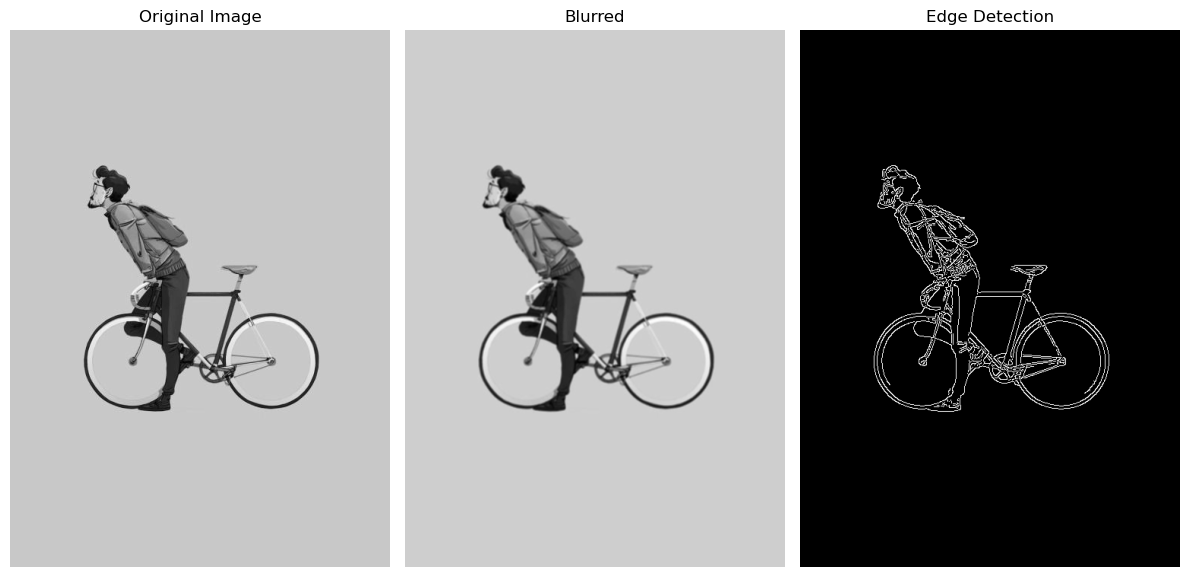

In [33]:
img_blur = cv2.GaussianBlur(img1, (3, 3), 1.5)
img_edges = cv2.Canny(img1, 50, 150)

plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(img1 , cmap = 'gray')
plt.title('Original Image')
plt.axis('off')



plt.subplot(1, 3, 2)
plt.imshow(img_blur, cmap='gray')
plt.title('Blurred')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_edges, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')

plt.tight_layout()
plt.show()


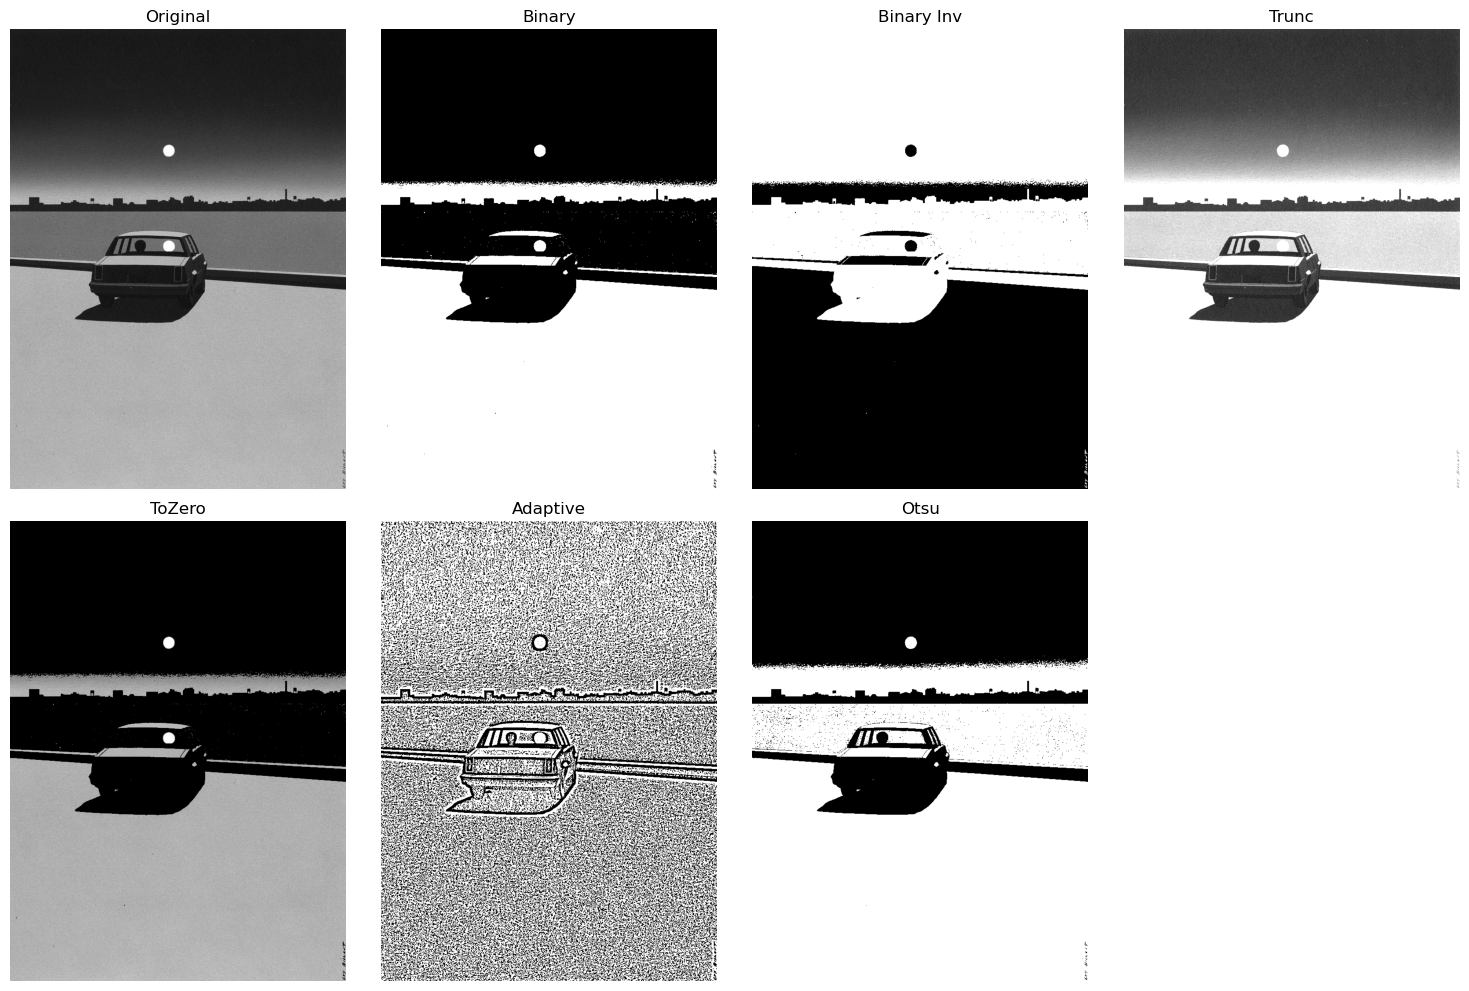

In [12]:

_, thresh_binary = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)
_, thresh_binary_inv = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY_INV)
_, thresh_trunc = cv2.threshold(img1, 127, 255, cv2.THRESH_TRUNC)
_, thresh_tozero = cv2.threshold(img1, 127, 255, cv2.THRESH_TOZERO)
thresh_adaptive = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_MEAN_C,    cv2.THRESH_BINARY, 11, 2)
_, thresh_otsu = cv2.threshold(img1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display results
images = [img1, thresh_binary, thresh_binary_inv, thresh_trunc, thresh_tozero, thresh_adaptive, thresh_otsu]
titles = ['Original', 'Binary', 'Binary Inv', 'Trunc', 'ToZero', 'Adaptive', 'Otsu']

plt.figure(figsize=(15, 10))
for i in range(7):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()